### Run imports

In [97]:
import cvxpy as cp

from battery_energy_trader.data_handler import DataHandler
from battery_energy_trader.optimizer import Optimizer


%reload_ext autoreload
%autoreload 2

### Data loading and preprocessing

In [98]:
# Path to the csv data file
file_path = 'data/Day-ahead_Prices_60min.csv'

# Initialize the data handler and load the data
data_handler = DataHandler(file_path, freq=60)

### Brief Data Analysis

Plot averaged daily prices to see pattern over weeks.

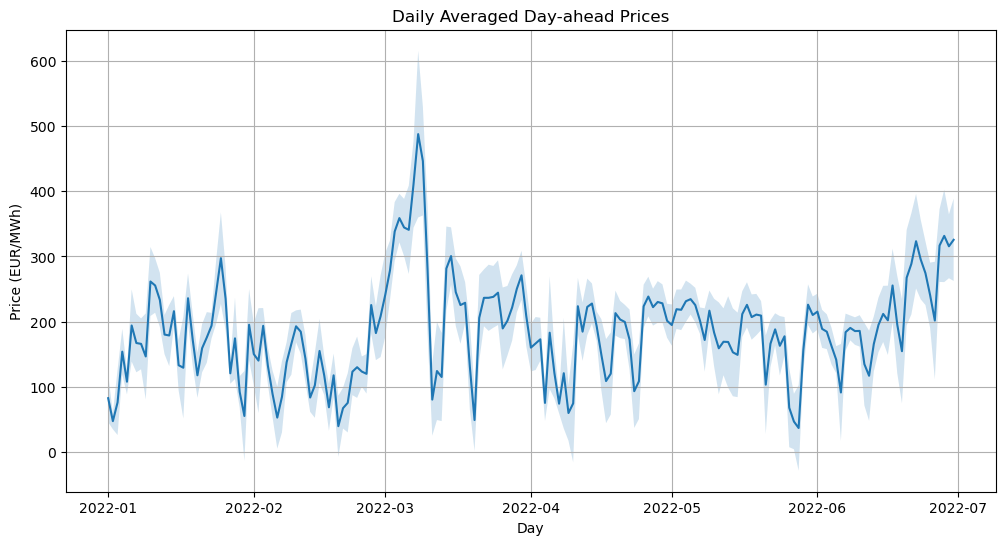

In [99]:
data_handler.plot_price_daily_averaged(plot_variance=True)

Plot hourly prices averaged over the whole dataset

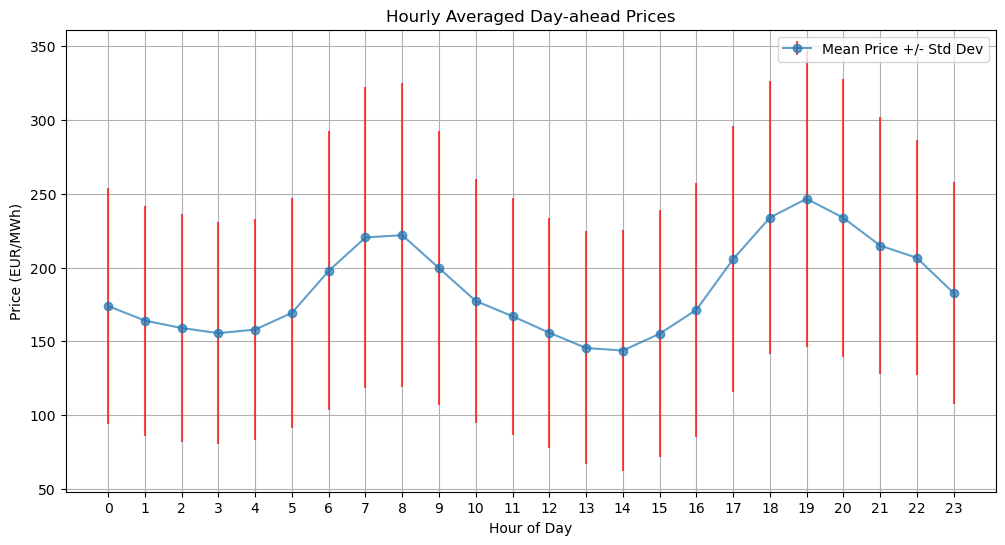

In [100]:
data_handler.plot_hourly_price_averaged(plot_variance=True)

We can can clearly see a cyclic behaviour of the prices (low during the night and around mid day) and high during the morning hours and evenings. This is might yield a promising trading strategy, i.e. buying around statistical "cheap hours" and selling at "expensive hours".

### Optimization problem
I use cvxpy because I'm familiar with it and cvxpy can solve convex optimization problems which is the case here.

#### Q1.1
We now solve for the setting of Question 1.1: **1MWh & 1MW**

In [101]:
optimizer = Optimizer(data_handler=data_handler, battery_capacity=1, max_power=1, efficiency=1)

#### Run LP
Run solver for each day using a Linear Program (LP) formulation.

The code is written s.t. we can optimize over different optimization horizons but we choose one day as specified in the task description.

The Linear Programming (LP) optimization problem for grid battery revenue maximization is defined as follows. The problem seeks to determine the optimal charging ($x_t$) and discharging ($y_t$) schedule of the battery over a given time horizon to maximize revenue from electricity trading, considering the price fluctuations and battery constraints.

### Parameters

- $T$: Total number of time intervals within the optimization horizon.
- $P_t$: Electricity price at time interval $t$, where $t = 1, \ldots, T$.
- $C$: Total battery capacity in MWh.
- $P_{\text{max}}$: Maximum power capacity for charging or discharging in MW.
- $\eta$: Charging and discharging efficiency of the battery.

### Decision Variables

- $x_t$: Power charged into the battery at time $t$ (in MW).
- $y_t$: Power discharged from the battery at time $t$ (in MW).
- $S_t$: State of charge of the battery at the end of time interval $t$ (in MWh).

### Objective Function

The objective is to maximize the total revenue from the operation of the battery:

$
\text{Maximize} \sum_{t=1}^{T} P_t \cdot (y_t - x_t)
$

### Constraints

1. **Battery State Dynamics**: The state of charge evolves according to the charging and discharging actions, factoring in the efficiency $\eta$:

$
S_t = S_{t-1} + \eta \cdot x_t - \frac{1}{\eta} \cdot y_t, \quad t = 1, \ldots, T
$

2. **State of Charge (SoC) Limits**: The SoC must remain within the physical limits of the battery's capacity:

$
0 \leq S_t \leq C, \quad t = 1, \ldots, T
$

3. **Charging and Discharging Rates**: The charging and discharging rates are limited by the battery's power capacity:

$
0 \leq x_t \leq P_{\text{max}}, \quad t = 1, \ldots, T
$

$
0 \leq y_t \leq P_{\text{max}}, \quad t = 1, \ldots, T
$

4. **Initial and Final SoC Matching** (Optional): If the optimization should consider a daily cyclic operation, the SoC at the end of the time horizon is constrained to be equal to the SoC at the beginning:

$
S_T = S_0 \quad (\text{if cyclic operation is enforced})
$

### Solution and Post-Processing

The problem is solved using an LP solver. Due to the linear nature of the problem, certain situations such as the simultaneous non-zero charging and discharging are mitigated in post-processing by setting small values to zero and ensuring that no simultaneous charging and discharging occurs.

### Results

The solution yields the optimal charging and discharging schedule and the corresponding state of charge over the time horizon, as well as the total profit achieved from the operation of the battery.


No constraint on the soc at the end of the day. We just start with the end soc of the previous day on the next day to ensure continuity.

In [102]:
optimizer.optimize_lp(time_horizon=1, solver=cp.ECOS, constraints_soc_end=False)

Total profit: 38897.21 EUR


With Constraint SOC at the end of the day again 0:

In [86]:
optimizer.optimize_lp(time_horizon=1, solver=cp.ECOS, constraints_soc_end=True)

Total profit: 36916.68 EUR


Less profit!

When we use a problem formulation like the above LP we cannot specify that we cannot simultaneously charge and discharge. Hence, when the optimal action is to hold the soc and neither charge nor discharge, the current solver will display this as charge = 0.5 MW and discharge = 0.5. Resulting in no flow and essentially holding the soc.
To enforce a behavior with both values beeing zero if the SOC should be constant we can formulize the problem as a Mixed-Integer Linear Program (MILP).
MILP can use binary varibales like is_charging to constraint this behavior.
-> For now we just use a post-processing step (in the optimize_lp method) to mitigate this issue.

#### Run MILP
MILP Formulation using GUROBI solver (license required) -> or i.e. GLPK_MI, CBC solver (open source)
We can use binary variables to enforce the behavior that the battery cannot charge and discharge simultaneously.
Using MILP might be more computationally expensive so in future work it might be interesting to compare the runtimes of both approaches.

The optimization problem being solved here aims to maximize the revenue from operating a grid-connected battery by buying (charging) electricity when prices are low and selling (discharging) when prices are high. The problem is formulated as a Mixed-Integer Linear Program (MILP) due to the inclusion of binary variables to enforce the condition that the battery cannot charge and discharge simultaneously.


### Parameters

- $T$: Total number of time intervals in the optimization horizon (for one day, $T = 24$ if hourly data).
- $P_t$: Electricity price at time interval $t$, $t = 1, \ldots, T$.
- $C$: Battery capacity in MWh.
- $P_{\text{max}}$: Maximum charging/discharging power of the battery in MW.
- $\eta$: Battery efficiency (a fraction between 0 and 1).

### Opt. Variables

- $x_t$: Amount of electricity charged into the battery at time $t$ (in MW).
- $y_t$: Amount of electricity discharged from the battery at time $t$ (in MW).
- $S_t$: State of charge of the battery at the end of time interval $t$ (in MWh).
- $\delta_t^+$: Binary variable indicating if the battery is charging at time $t$ (1 if charging, 0 otherwise).
- $\delta_t^-$: Binary variable indicating if the battery is discharging at time $t$ (1 if discharging, 0 otherwise).

### Objective Function

Maximize the total revenue from battery operation:

$
\text{Maximize} \sum_{t=1}^{T} P_t \cdot (y_t - x_t)
$

### Constraints

1. **Battery dynamics**: The state of charge is updated based on charging and discharging actions, considering efficiency $\eta$.

$
S_{t} = S_{t-1} + \eta \cdot x_t - \frac{1}{\eta} \cdot y_t, \quad t = 1, \ldots, T
$

2. **State of charge limits**: The state of charge must not exceed the battery capacity nor go below zero.

$
0 \leq S_t \leq C, \quad t = 1, \ldots, T
$

3. **Charging and discharging limits**: The amount of charging/discharging at any time is limited by the battery's maximum power. Binary variables $\delta_t^+$ and $\delta_t^-$ enforce whether the battery can charge or discharge.

$
0 \leq x_t \leq P_{\text{max}} \cdot \delta_t^+, \quad t = 1, \ldots, T
$

$
0 \leq y_t \leq P_{\text{max}} \cdot \delta_t^-, \quad t = 1, \ldots, T
$

4. **Mutual exclusivity of charging and discharging**:

$
\delta_t^+ + \delta_t^- \leq 1, \quad t = 1, \ldots, T
$

5. **Initial and final state of charge**: Depending on the problem setup, the initial SOC can be set to zero or a specified value, and the final SOC can be constrained to match the initial SOC for cyclic operation.

$
S_0 = \text{specified initial SOC}
$

$
S_T = S_0 \quad (\text{if cyclic operation is enforced})
$

### Notes

- This formulation captures the core aspects of the battery operation optimization problem, including the decision-making process about when to charge or discharge the battery based on electricity prices, while respecting the physical constraints of the battery system.
- The binary variables $\delta_t^+$ and $\delta_t^-$ ensure that the battery does not charge and discharge simultaneously, adding the mixed-integer aspect to the linear programming problem.
- Efficiency $\eta$ is accounted for in both charging and discharging processes to reflect real-world energy losses.

No constraint on the soc at the end of the day. We just start with the end soc of the previous day on the next day to ensure continuity.

In [87]:
optimizer.optimize_milp(time_horizon=1, solver=cp.GLPK_MI, constraints_soc_end=False)

Total profit: 38897.21 EUR


With Constraint SOC at the end of the day again 0:

In [79]:
optimizer.optimize_milp(time_horizon=1, solver=cp.GLPK_MI, constraints_soc_end=True)

Total profit: 36916.68 EUR


Less profit. -> TODO: check if we might need to model the continous soc state differently (last soc value of the day) -> soc = cp.Variable(((end_day - start_day)) * self.data_handler.data_points_per_day+1) instead of soc = cp.Variable(((end_day - start_day)) * self.data_handler.data_points_per_day) 

--> this results in a profit of **66618.78 EUR**

In [80]:
optimizer.optimize_milp(time_horizon=1, solver=cp.GLPK_MI, constraints_soc_end=False)

Total profit: 38897.21 EUR


### Data analysis and visualization

Plot daily profit over time

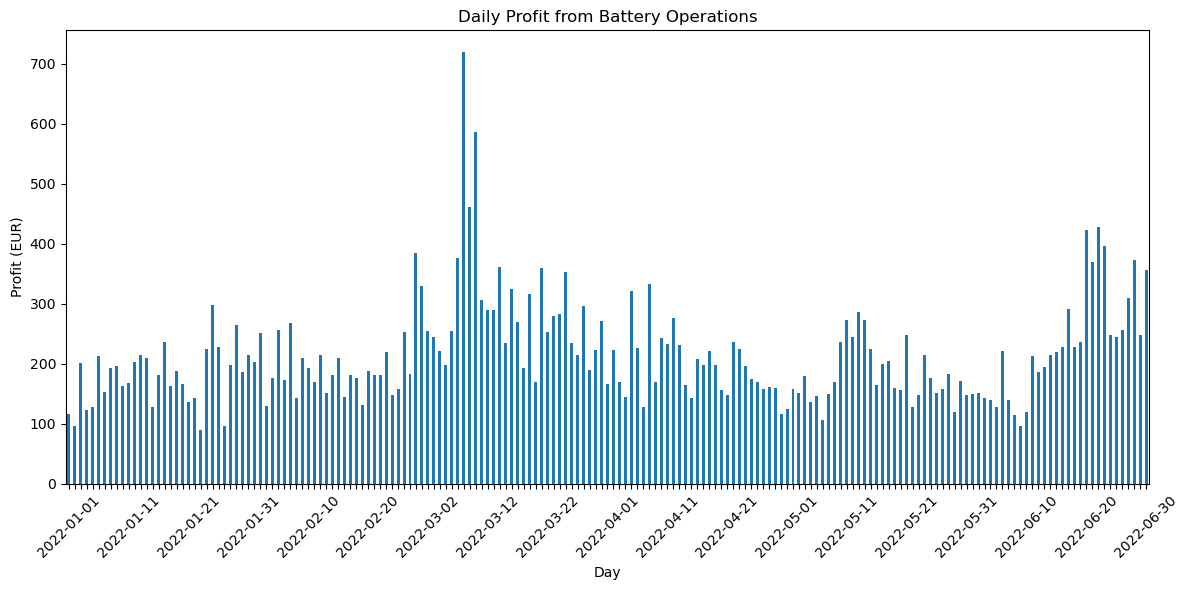

In [88]:
data_handler.plot_daily_profit()

Plot average charging and discharging rates by hour of day

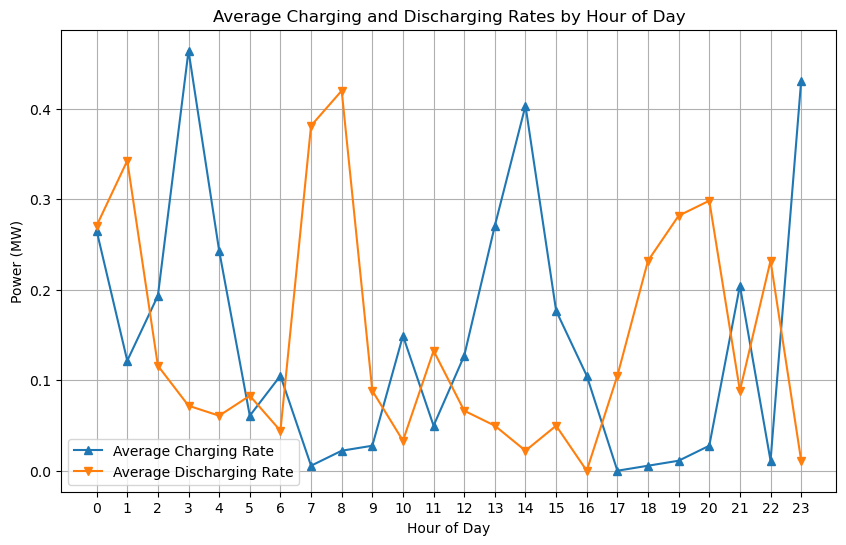

In [89]:
data_handler.plot_averaged_charge_discharge_over_day()

Plot SoC for one day as an example

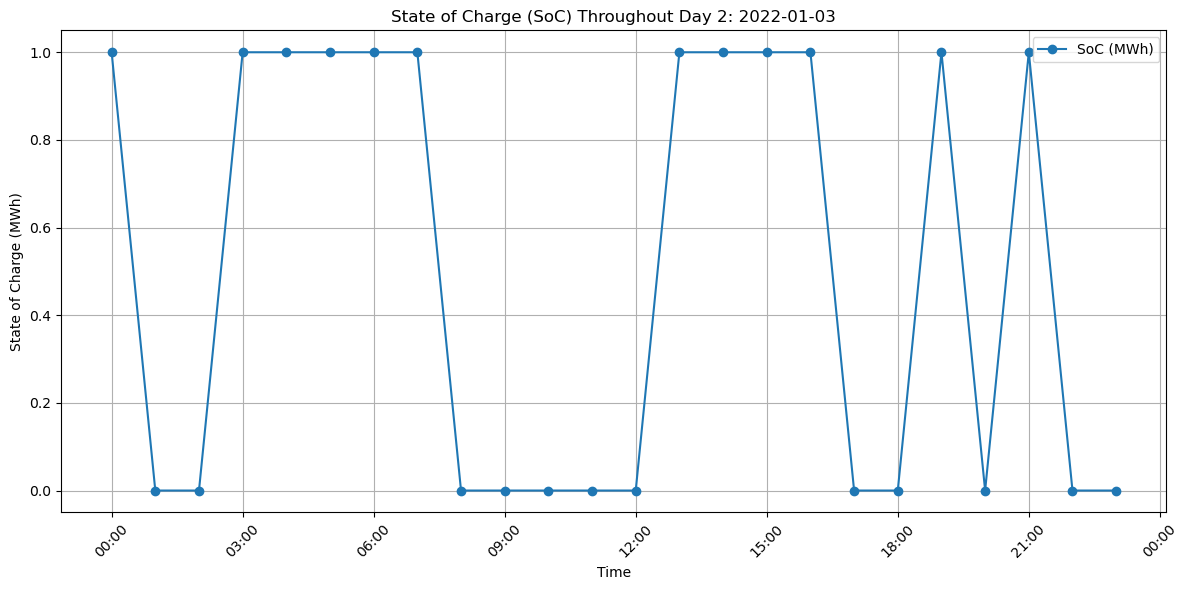

In [54]:
data_handler.plot_soc(day=2)

## Q1.2
We now solve for the setting of Question 1.2: **2MWh & 1MW**

In [103]:
optimizer = Optimizer(data_handler=data_handler, battery_capacity=2, max_power=1, efficiency=1)

#### Run LP
Run solver for each day using a Linear Program (LP) formulation.

The code is written s.t. we can optimize over different optimization horizons but we choose one day as specified in the task description.

In [91]:
optimizer.optimize_lp(time_horizon=1, solver=cp.ECOS, constraints_soc_end=False)

Total profit: 69380.34 EUR


When we use a problem formulation like the above LP we cannot specify that we cannot simultaneously charge and discharge. Hence, when the optimal action is to hold the soc and neither charge nor discharge, the current solver will display this as charge = 0.5 MW and discharge = 0.5. Resulting in no flow and essentially holding the soc.
To enforce a behavior with both values beeing zero if the SOC should be constant we can formulize the problem as a Mixed-Integer Linear Program (MILP).
MILP can use binary varibales like is_charging to constraint this behavior.
-> For now we just use a post-processing step (in the optimize_lp method) to mitigate this issue.

#### Run MILP
MILP Formulation using GUROBI solver (license required) -> or i.e. CBC solver (open source)
We can use binary variables to enforce the behavior that the battery cannot charge and discharge simultaneously.
Using MILP might be more computationally expensive so in future work it might be interesting to compare the runtimes of both approaches.

In [92]:
optimizer.optimize_milp(time_horizon=1, solver=cp.GUROBI, constraints_soc_end=False)

Total profit: 69380.34 EUR


### Data analysis and visualization

Plot daily profit over time

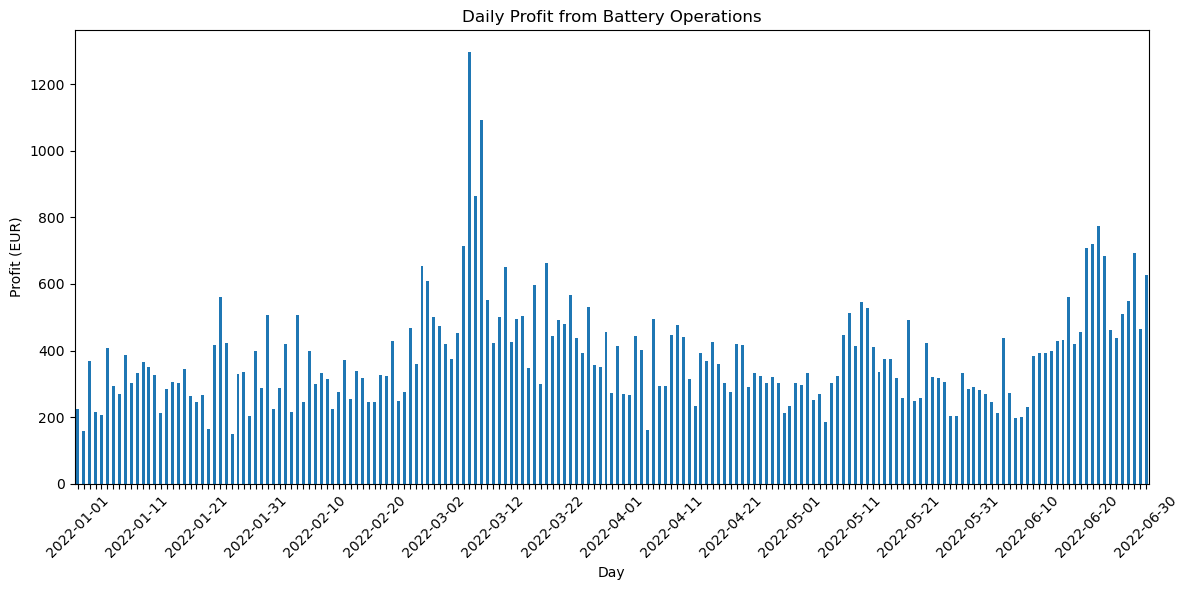

In [93]:
data_handler.plot_daily_profit()

Plot average charging and discharging rates by hour of day

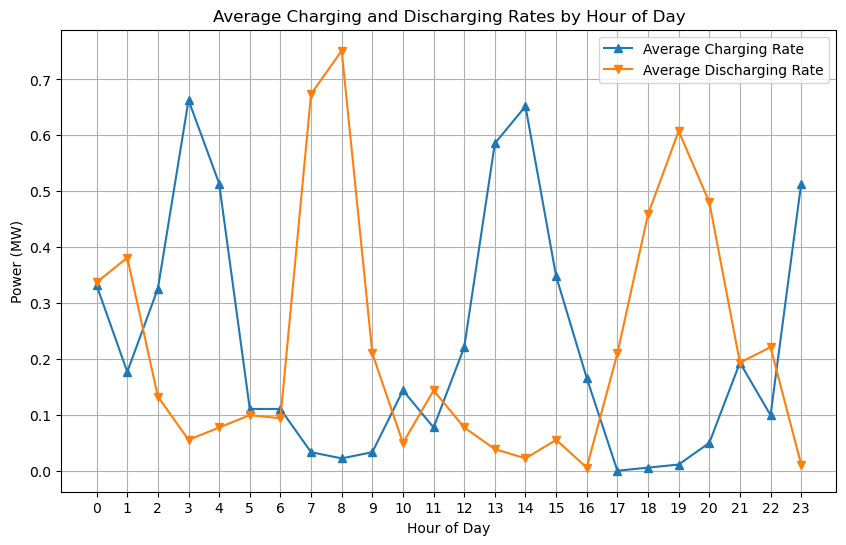

In [94]:
data_handler.plot_averaged_charge_discharge_over_day()

Plot SoC for one day as an example

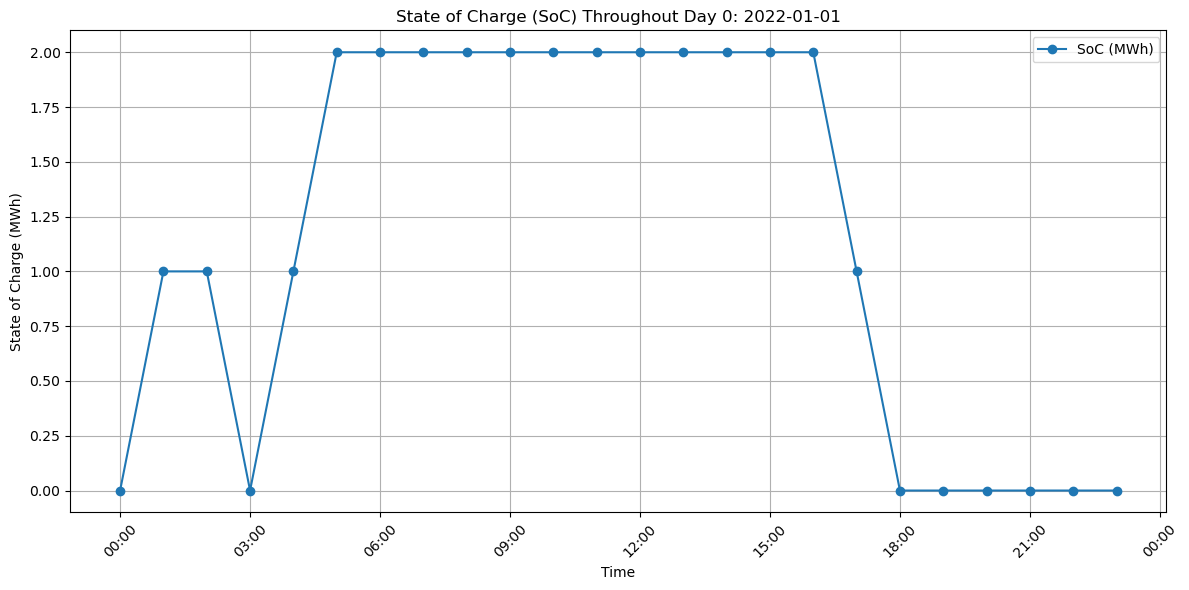

In [95]:
data_handler.plot_soc(day=0)

In [89]:
# TODO: check what happens if we optimize over the full time horizon and not just day by day -> influence of different time horizons on the results
# TODO: implement cycle tracking for lifetime analysis and potential degradation costs/optimization